In [1]:
# Setup
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
###
# Entity Embeddings
###

# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J)+1
Y = df['x_republican'] > 0
Y2 = df['log_cite_count']

In [3]:
# set up DNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(num_judges, # number of categories
                    2, # dimensions of embedding
                    input_length=1)) 
model.add(Flatten()) # needed after Embedding
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#dot = model_to_dot(model,
#                   show_shapes=True,
#                   show_layer_names=False)
#SVG(dot.create(prog='dot', format='svg'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 2)              22        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


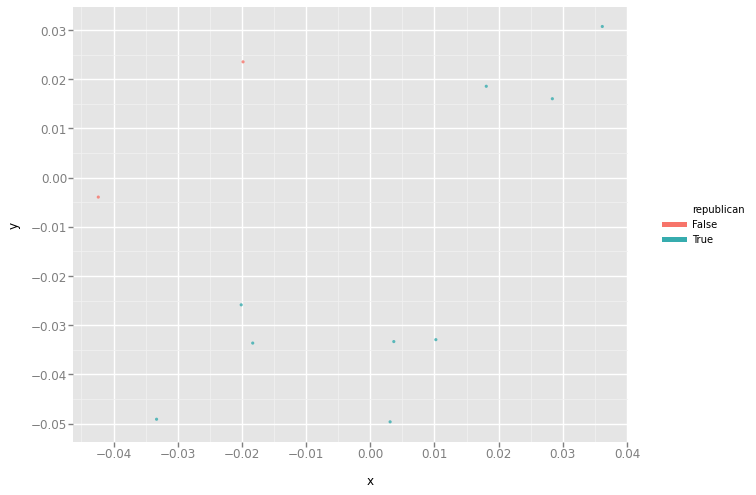


Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 251us/step - loss: 0.6815 - accuracy: 0.8388 - val_loss: 0.6706 - val_accuracy: 0.7662


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


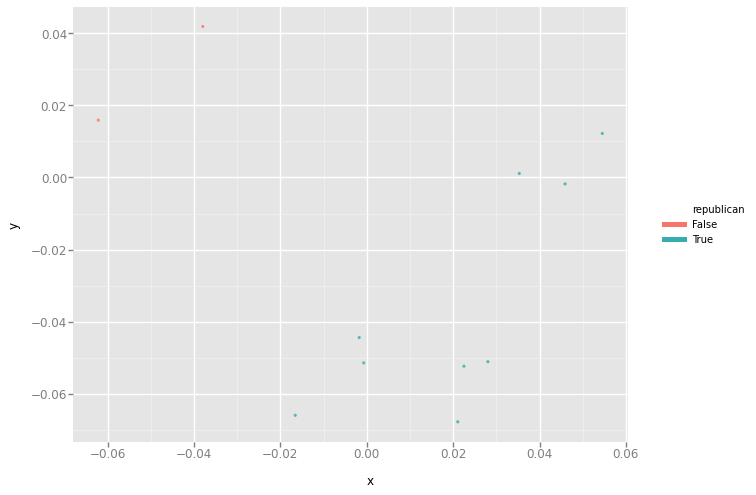

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 35us/step - loss: 0.6611 - accuracy: 0.7752 - val_loss: 0.6500 - val_accuracy: 0.7662


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


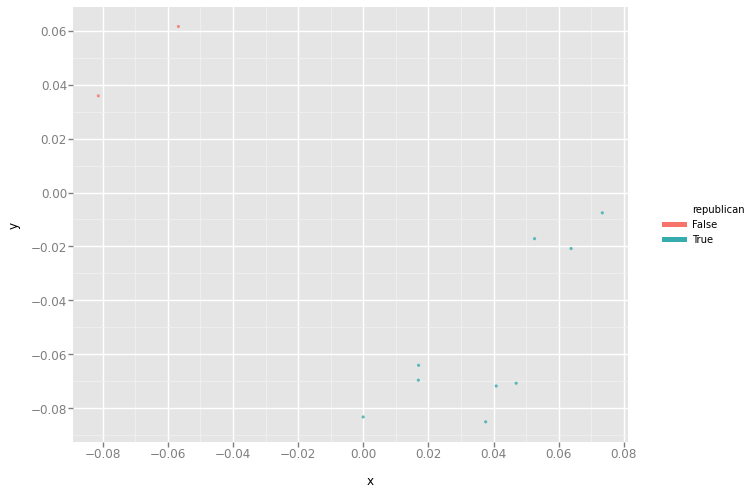

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 32us/step - loss: 0.6392 - accuracy: 0.7752 - val_loss: 0.6271 - val_accuracy: 0.7662


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


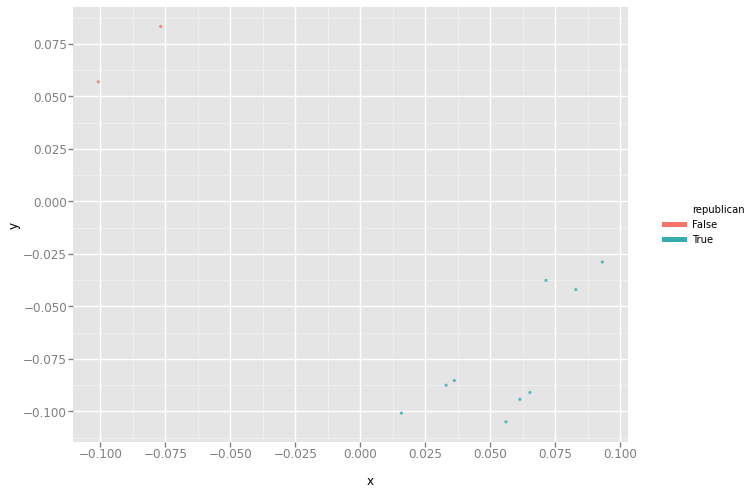

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 32us/step - loss: 0.6154 - accuracy: 0.7752 - val_loss: 0.6026 - val_accuracy: 0.7662


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


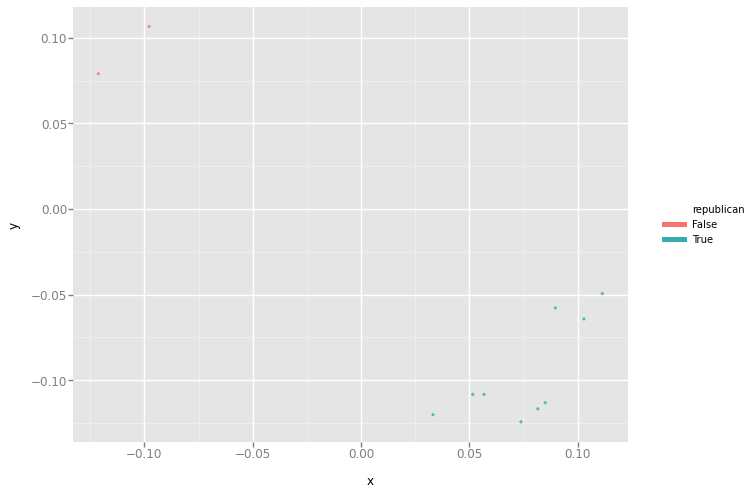

In [5]:
# Visualize the Judge Vectors
import ggplot as gg
judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['republican'] = df2['authorship'].apply(lambda x: judge_cites[x])

for i in range(5):
    if i > 0:
        model.fit(J,Y,epochs=1, validation_split=.2)
    
    judge_vectors = model.layers[0].get_weights()[0]
    df2['x'] = judge_vectors[:,0]
    df2['y'] = judge_vectors[:,1]    
    chart = gg.ggplot( df2, gg.aes(x='x', y='y', color='republican') ) \
                      + gg.geom_point(size=10, alpha=.8) 
    chart.show()

In [6]:
# Word Embeddings

# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['opinion_text'])
sequences = tokenizer.texts_to_sequences(df['opinion_text'])

# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 
maxlen

13971

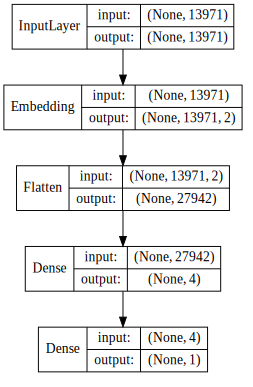

In [7]:
X = pad_sequences(sequences, maxlen=maxlen)

# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(4))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)
dot = model_to_dot(model, show_shapes=True, show_layer_names=False,  dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 13971, 2)          400       
_________________________________________________________________
flatten_2 (Flatten)          (None, 27942)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 111772    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 112,177
Trainable params: 112,177
Non-trainable params: 0
_________________________________________________________________


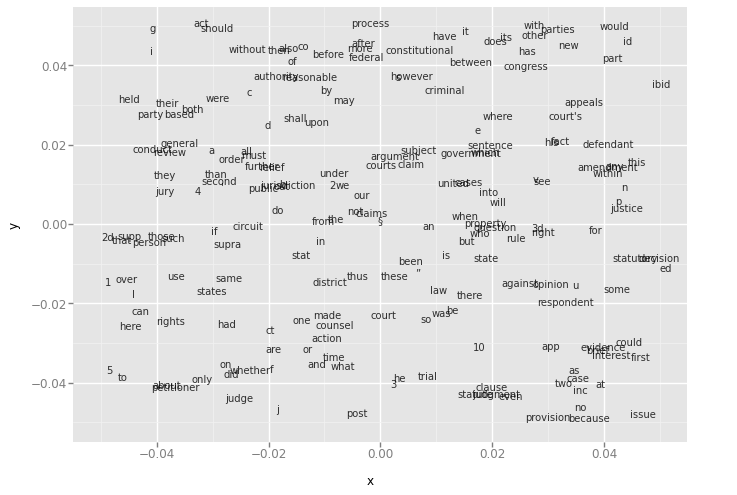

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 1s 1ms/step - loss: 1.2318 - val_loss: 0.5603


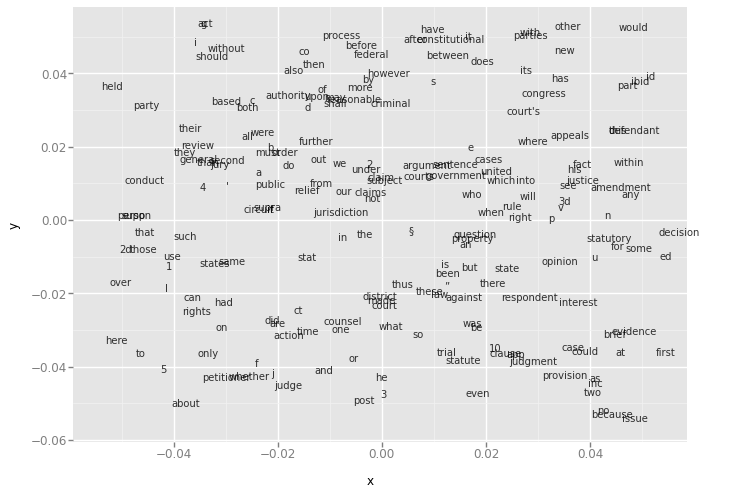

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 1s 824us/step - loss: 0.4908 - val_loss: 0.5529


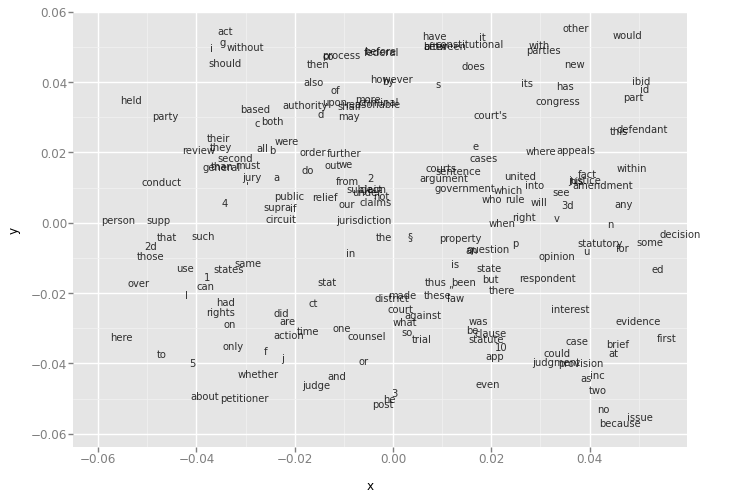

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 790us/step - loss: 0.4474 - val_loss: 0.5500


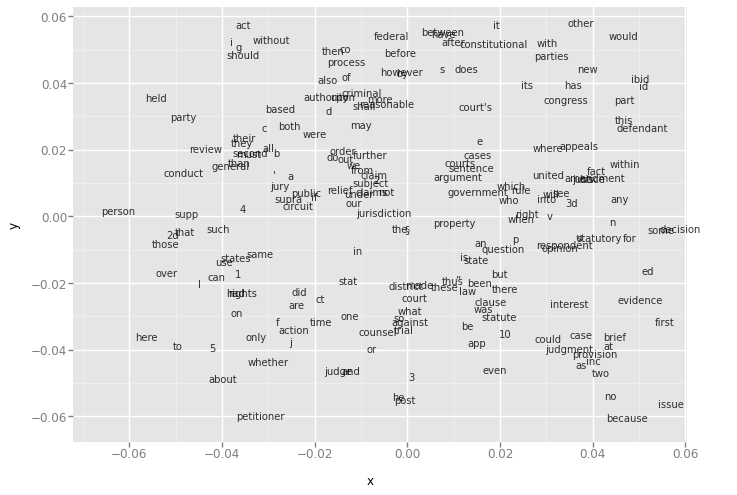

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 0s 793us/step - loss: 0.3921 - val_loss: 0.5475


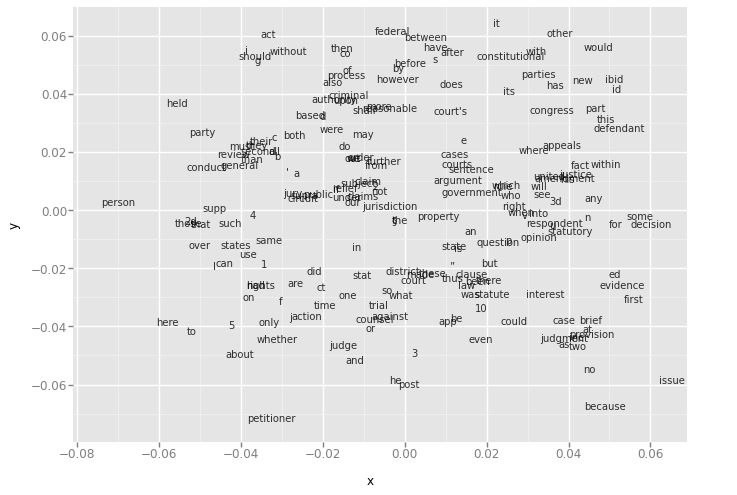

In [9]:
# show the vectors
df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(5):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df3['x'] = word_vectors[:,0]
    df3['y'] = word_vectors[:,1]
    chart = gg.ggplot( df3, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

In [10]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[tokenizer.word_index['federal']-1]
vec_convicted = word_vectors[tokenizer.word_index['constitutional']-1]
vec_against = word_vectors[tokenizer.word_index['state']-1]

print(1-cosine(vec_defendants, vec_convicted))

0.9025951027870178


In [11]:
print(1-cosine(vec_defendants, vec_against))

-0.8977670669555664


In [12]:
###
# Word2Vec in gensim
###

# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([-4.34245579e-02,  1.34630293e-01,  6.99003115e-02,  3.58330049e-02,
       -1.19303644e-01, -5.85756190e-02, -6.61779344e-02,  5.42641468e-02,
       -6.74008206e-02, -7.68585801e-02, -4.02941070e-02,  1.04538547e-02,
        2.24371422e-02, -2.41934694e-02, -3.39004397e-02,  1.11329094e-01,
        5.80643415e-02,  1.20843397e-02, -9.84363630e-03, -7.15703145e-02,
        2.81161852e-02, -2.67784053e-04, -4.81584147e-02, -4.59033363e-02,
        5.79177141e-02,  7.52914771e-02, -8.71135388e-03, -5.00274226e-02,
       -3.68946902e-02,  1.80985574e-02, -6.23022281e-02, -7.77484402e-02,
       -3.61312032e-02, -8.29863027e-02, -4.40933071e-02,  9.10881087e-02,
        4.28854078e-02, -2.22162735e-02,  4.71196808e-02,  9.10803676e-02,
        1.45468758e-02,  1.01656891e-01, -4.29827645e-02,  7.64269680e-02,
       -5.48628271e-02, -2.84180371e-03, -1.42219961e-02,  2.51372550e-02,
       -6.01300932e-02, -4.76052612e-02, -1.65317245e-02,  2.36590300e-02,
        2.68006250e-02,  

In [13]:
w2v.wv.similarity('judg','juri') # similarity 

0.57495385

In [14]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.6230942606925964),
 ('juri', 0.5749538540840149),
 ('court', 0.5536344051361084),
 ('factfind', 0.5474344491958618),
 ('speedi', 0.5208197832107544),
 ('mistrial', 0.5170762538909912),
 ('panel', 0.5144498348236084),
 ('prosecutor', 0.5143032073974609),
 ('erron', 0.509736180305481),
 ('imparti', 0.48753148317337036)]

In [15]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('bench', 0.5811508893966675),
 ('magistr', 0.518891453742981),
 ('sit', 0.4986225366592407),
 ('panel', 0.4908500015735626),
 ('mistrial', 0.4818897247314453),
 ('oath', 0.4767524003982544),
 ('juri', 0.4687604308128357),
 ('prosecutor', 0.46247291564941406),
 ('unanim', 0.46151265501976013),
 ('erron', 0.4386773407459259)]

In [16]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index2word[i])

court
district
appeal
decis
judgment
order
review
circuit
judg
grant


In [17]:
###
# Pre-trained vectors
###

import spacy
en = spacy.load('en_core_web_lg')
apple = en('apple') 
apple.vector # vector for 'apple'

array([-3.6391e-01,  4.3771e-01, -2.0447e-01, -2.2889e-01, -1.4227e-01,
        2.7396e-01, -1.1435e-02, -1.8578e-01,  3.7361e-01,  7.5339e-01,
       -3.0591e-01,  2.3741e-02, -7.7876e-01, -1.3802e-01,  6.6992e-02,
       -6.4303e-02, -4.0024e-01,  1.5309e+00, -1.3897e-02, -1.5657e-01,
        2.5366e-01,  2.1610e-01, -3.2720e-01,  3.4974e-01, -6.4845e-02,
       -2.9501e-01, -6.3923e-01, -6.2017e-02,  2.4559e-01, -6.9334e-02,
       -3.9967e-01,  3.0925e-02,  4.9033e-01,  6.7524e-01,  1.9481e-01,
        5.1488e-01, -3.1149e-01, -7.9939e-02, -6.2096e-01, -5.3277e-03,
       -1.1264e-01,  8.3528e-02, -7.6947e-03, -1.0788e-01,  1.6628e-01,
        4.2273e-01, -1.9009e-01, -2.9035e-01,  4.5630e-02,  1.0120e-01,
       -4.0855e-01, -3.5000e-01, -3.6175e-01, -4.1396e-01,  5.9485e-01,
       -1.1524e+00,  3.2424e-02,  3.4364e-01, -1.9209e-01,  4.3255e-02,
        4.9227e-02, -5.4258e-01,  9.1275e-01,  2.9576e-01,  2.3658e-02,
       -6.8737e-01, -1.9503e-01, -1.1059e-01, -2.2567e-01,  2.41

In [18]:
apple.similarity(apple)

1.0

In [19]:
orange = en('orange')
apple.similarity(orange)

0.5618917538704213

In [21]:
import spacy
de = spacy.load('de')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

0.7104687835520671

In [22]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [23]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 13971, 300)        60000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4191300)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                268243264 
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 268,303,329
Trainable params: 268,243,329
Non-trainable params: 60,000
_________________________________________________________________


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.064958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.772675
[t-SNE] KL divergence after 300 iterations: 1.192712


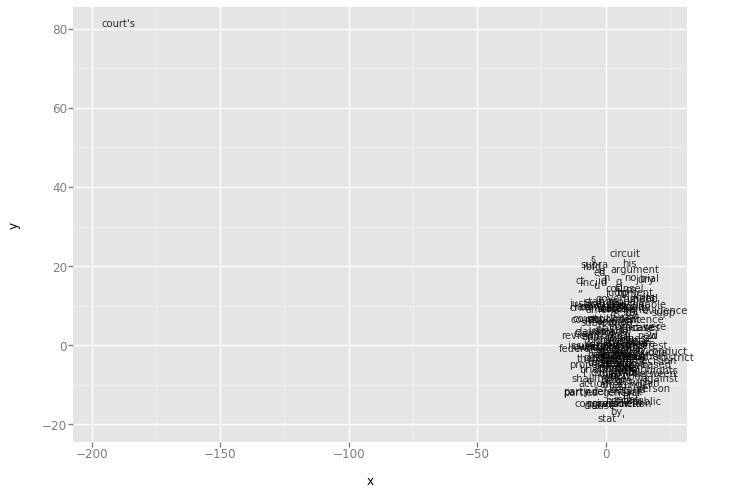

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 47s 76ms/step - loss: 3.3993 - accuracy: 0.0375 - val_loss: 3.5844 - val_accuracy: 0.0000e+00
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.064958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.494858
[t-SNE] KL divergence after 300 iterations: 0.982956


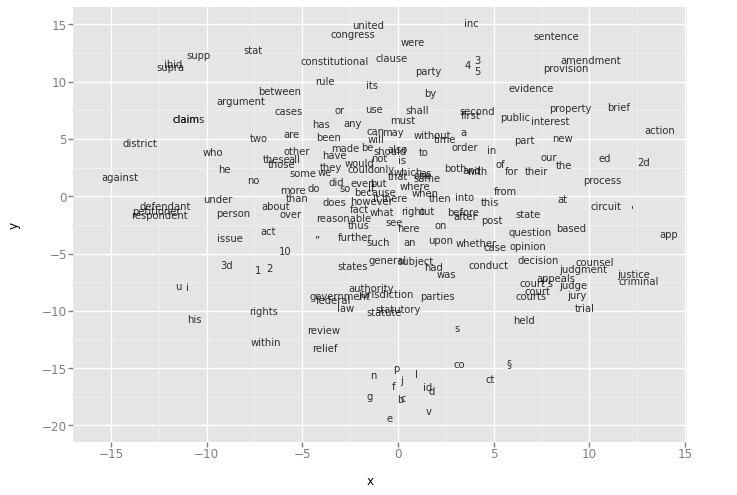

Train on 614 samples, validate on 154 samples
Epoch 1/1
614/614 [==============================] - 47s 77ms/step - loss: 3.4462 - accuracy: 0.0000e+00 - val_loss: 3.5844 - val_accuracy: 0.0000e+00
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.064958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.995361
[t-SNE] KL divergence after 300 iterations: 1.048099


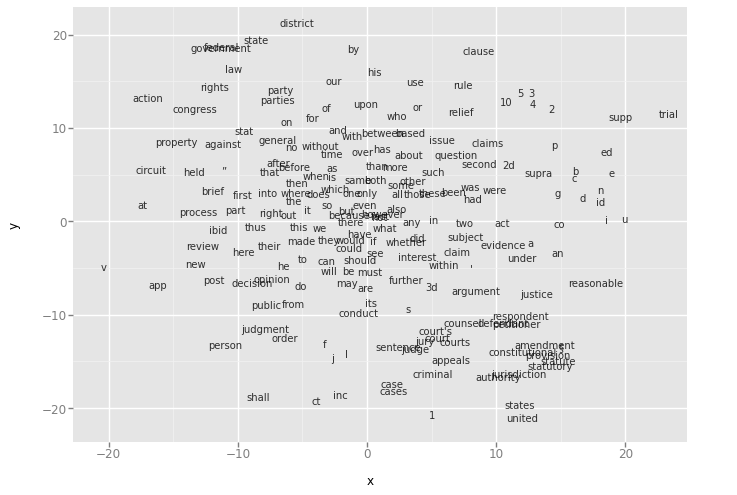

In [25]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    chart = gg.ggplot( df3, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

In [26]:
###
# Word Mover Distance
###

import spacy
import wmd
nlp = spacy.load('en', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

0.7215200499755977
